In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import os
import xgboost as lgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=4

In [3]:
print FOLD

4


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz",
                                     with_l2=True,with_l3=True,with_l4=True,with_l5=True)
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

0

# cv

In [9]:
n_reg_lookback=7
n_lookforward=1
n_offset=0

In [10]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 
                'visitor_ma7', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 
                'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 
                'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'geo2_visitors_mean', 
                'station_visitors_mean', 'geo2_count_y1', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 
                'station_count_y3', 'station_count_y4',
               's16_y_nan', 's16_y_std', 's16_y1_ratio', 's16_y2_ratio',
               'bad_ratio'])
len(lag_cols)

32

In [11]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [12]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean',
                    '3003nb_conv_fold{}_False_d478.pkl', '3005_rf_fold{}_False_d478.pkl', '3001eb_lgb_fold{}_True_d478.pkl', '3002nb_lstm_fold{}_False_d478.pkl', '3000eb_ridge_fold{}_True_d478.pkl', '3002_lstm_fold{}_False_d478.pkl', '3006_xgb_fold{}_False_d478.pkl', '3003_conv_fold{}_False_d478.pkl', '3000_ridge_fold{}_False_d478.pkl', '3001_lgb_fold{}_False_d478.pkl'                                                            ,
                    'l2_3000_ridge_fold{}_False_d478.pkl', 'l2_3003_conv_fold{}_False_d478.pkl', 'l2_3001_lgb_fold{}_False_d478.pkl', 'l2_3006_xgb_fold{}_False_d478.pkl'                   ,
                    'l3_3000_ridge_fold{}_False_d478.pkl', 'l3_3003_conv_fold{}_False_d478.pkl', 'l3_3006_xgb_fold{}_False_d478.pkl', 'l3_3001_lgb_fold{}_False_d478.pkl'                    ,
                    'l4_3006_xgb_fold{}_False_d478.pkl', 'l4_3000_ridge_fold{}_False_d478.pkl', 'l4_3001_lgb_fold{}_False_d478.pkl', 'l4_3003_conv_fold{}_False_d478.pkl'                    
                    
                   ])

In [13]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    #lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [14]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

# time split

In [15]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [16]:
def make_Xy(data_from_gen):
    print data_from_gen[0]['ondatex'].shape,data_from_gen[0]['lagx'].shape,data_from_gen[0]['masky'].shape,data_from_gen[1].shape
    X=np.concatenate([data_from_gen[0]['ondatex'].reshape([data_from_gen[0]['ondatex'].shape[0],-1]),
                    data_from_gen[0]['lagx'].reshape([data_from_gen[0]['lagx'].shape[0],-1])],axis=1)
    y=np.squeeze(data_from_gen[1])
    mask=np.squeeze(data_from_gen[0]['masky'].reshape([data_from_gen[0]['masky'].shape[0],-1]))
    print X.shape,y.shape,mask.shape
    mask= (mask>0) & (y>0)
    X=X[mask]
    y=y[mask]
    dataidx=data_from_gen[3][mask]
    assert X.shape[0]==y.shape[0]
    return X,y,dataidx

In [17]:
from sklearn.metrics import mean_squared_error
def make_model(i, trainX,trainy, validX,validy, colsample_bytree=1,max_depth=4,subsample=1,C=0.1,
                                    learning_rate=0.02,min_child_weight=1,objective='reg:l1f0',
                                     gamma=0,reg_alpha=0,reg_lambda=1 ):
        models=[]
        scores=[]
        d_train = lgb.DMatrix(trainX, label=trainy)
        d_valid = lgb.DMatrix(validX, label=validy)
        
        if 1:
            params = {}
            params['eta'] = learning_rate
            params['objective'] = objective
            params['eval_metric'] = 'rmse'
            params['max_depth'] = max_depth
            params['colsample_bytree'] = colsample_bytree
            params['subsample'] = subsample
            params['min_child_weight'] = min_child_weight 
            params['gamma'] = gamma            
            params['reg_alpha'] = reg_alpha            
            params['reg_lambda'] = reg_lambda            
            params['silent'] = 1
            params['nthread'] = 8
            params['tree_method']='hist'
            print i, params
            watchlist = [(d_train, 'train'), (d_valid, 'valid')]
            
            gbm = lgb.train(params, d_train, 1000, watchlist, early_stopping_rounds=50, verbose_eval=50)


            models.append(gbm)
            validpred=gbm.predict(d_valid,ntree_limit=gbm.best_ntree_limit)
            scores.append(mean_squared_error(validy,validpred))
            print mean_squared_error(trainy,gbm.predict(d_train,ntree_limit=gbm.best_ntree_limit)), scores[-1]
        print scores
        print i, "mean score", np.mean(scores)
        return models[0],np.mean(scores),validpred
        #return np.mean(scores) 

In [18]:
def f(iparam,trainX,trainy,validX,validy):
    i,param=iparam
    return make_model(i,trainX,trainy,validX,validy, **param)

In [19]:
import rrvf_data
def g(model,testX,testy,testidx,n_offset):
    d_test = lgb.DMatrix(testX, label=testy)    
    test_pred=model.predict(d_test,ntree_limit=model.best_ntree_limit)    
    df=pd.DataFrame({'y':testy})
    df['pred']=test_pred
    df['dayidx']=testidx[:,1]+n_offset
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

def g2(model,train_gen,offset):
    predlist=[]
    ylist=[]
    daylist=[]
    for i in range(7):
        i=478-7+i-offset
        Xdict,y,dataidx,_=train_gen.get_by_t2(day=i)
        X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
        d_test = lgb.DMatrix(X)    
        pred=model.predict(d_test,ntree_limit=model.best_ntree_limit).reshape(-1)
        predlist.append(pred)
        daylist.append(np.zeros_like(pred,dtype=int)+i+offset)
        ylist.append(y.reshape(-1))
    ylist=np.concatenate(ylist)
    predlist=np.concatenate(predlist)
    daylist=np.concatenate(daylist)
    df=pd.DataFrame({'y':ylist,'dayidx':daylist,'pred':predlist})
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

PRED_DATE=478
def h(model,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
    #mask=np.squeeze(Xdict['masky'].reshape([Xdict.shape[0],-1]))
    print X.shape
    d_test = lgb.DMatrix(X)    
    pred=model.predict(d_test,ntree_limit=model.best_ntree_limit)

    return pred,dataidx


In [20]:
parameter={'colsample_bytree': 0.5,
 'learning_rate': 0.02,
 'max_depth': 8,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'subsample': 1}

In [21]:
EXCLUDE_HARD=False
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    assert n_offset+1==n_lookforward
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,#478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward, excluded_days=None)
    valid_gen=None
    test_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    train_data_from_gen=train_gen.get_train()
    trainX,trainy,_=make_Xy(train_data_from_gen)
    valid_data_from_gen=train_gen.get_valid()
    validX,validy,valididx=make_Xy(valid_data_from_gen)
    test_data_from_gen=test_gen.get_train()
    testX,testy,testidx=make_Xy(test_data_from_gen)

    model,score,validpred=f((-1,parameter),trainX,trainy,validX,validy)
    g(model,testX,testy,testidx,n_offset)
    g2(model,train_gen,n_offset)
    
    pred478=h(model,train_gen)
    return score,(validy,valididx,validpred),pred478

def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    return _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)        

In [22]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [23]:
def ff(offset):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)
    _,validpred,pred478=run_once(columns,data,rawy, indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    #validpreds[offset]=[validpred,pred478]
    return offset, [validpred,pred478]
    #pickle.dump(validpreds, open('3005_rf_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))    

In [24]:
j=FOLD
validpreds={}

In [25]:
p = Pool(1,maxtasksperchild=1)



1
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 14.804288
(829, 517, 40)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 5803 records out of 5803 records
no valid set
1572
0
(201296, 1, 40) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 264) (201296,) (201296,)
(49444, 1, 40) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 264) (49444,) (49444,)
(5803, 1, 40) (5803, 7, 32) (5803, 1) (5803, 1)
(5803, 264) (5803,) (5803,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38602	valid-rmse:2.42536
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.98021	valid-rmse:0.996393
[100]	train-rmse:0.571964	valid-rmse:0.584465
[150]	train-rmse:0.488635	valid-rmse:0.504384
[200]	train-rmse:0.472768	valid-rmse:0.492529
[250]	train-rmse:0.46719	valid-rmse:0.490919
[300]	train-rmse:0.463298	valid-rmse:0.490732
[350]	train-rmse:0.460865	valid-rmse:0.490765
Stopping. Best iteration:
[307]	train-rmse:0.46292	valid-rmse:0.490731

0.21429443 0.24081731
[0.24081731]
-1 mean score 0.24081731
0.193099752069


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.926206  0.002904  0.201342    7  2017-04-16
472     2.507290  2.526212 -0.018921  0.204916    1  2017-04-17
473     2.661330  2.664259 -0.002929  0.226997    2  2017-04-18
474     2.754815  2.744434  0.010381  0.195236    3  2017-04-19
475     2.713762  2.709357  0.004405  0.212618    4  2017-04-20
476     2.999000  2.983636  0.015364  0.142637    5  2017-04-21
477     3.075529  3.079063 -0.003534  0.167953    6  2017-04-22

0.193099752069


pred         y     error    error2  day        date
dayidx                                                         
471     2.926206  2.929110  0.002904  0.201342    7  2017-04-16
472     2.526212  2.507290 -0.018921  0.204916    1  2017-04-17
473     2.664259  2.661330 -0.002929  0.226997    2  2017-04-18
474     2.744434  2.754815  0.010381  0.195236    3  2017-04-19
475     2.709357  2.713762  0.004405  0.212618    4  2017-04-20
476     2.983636  2.999000  0.015364  0.142637    5  2017-04-21
477     3.079063  3.075529 -0.003534  0.167953    6  2017-04-22

(829, 264)


In [26]:
results=p.map(ff, range(1,40),chunksize=1)



2
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 14.804288
(829, 517, 40)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201067, 2) (49390, 2)
train/valid # (201067, 2) (49390, 2)
rand split across time
train has 201067 records out of 389630 records
valid has 49390 records out of 389630 records
train has 6632 records out of 6632 records
no valid set
1570
0
(201067, 1, 40) (201067, 7, 32) (201067, 1) (201067, 1)
(201067, 264) (201067,) (201067,)
(49390, 1, 40) (49390, 7, 32) (49390, 1) (49390, 1)
(49390, 264) (49390,) (49390,)
(6632, 1, 40) (6632, 7, 32) (6632, 1) (6632, 1)
(6632, 264) (6632,) (6632,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38581	valid-rmse:2.42506
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.982504	valid-rmse:0.995275
[100]	train-rmse:0.576201	valid-rmse:0.585515
[150]	train-rmse:0.493034	valid-rmse:0.507286
[200]	train-rmse:0.476769	valid-rmse:0.496113
[250]	train-rmse:0.470986	valid-rmse:0.494715
[300]	train-rmse:0.466987	valid-rmse:0.494546
Stopping. Best iteration:
[285]	train-rmse:0.468025	valid-rmse:0.494527

0.21904695 0.24455649
[0.24455649]
-1 mean score 0.24455649
0.197412386537


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.913879  0.015231  0.212979    7  2017-04-16
472     2.507290  2.524980 -0.017689  0.207622    1  2017-04-17
473     2.661330  2.659772  0.001557  0.230219    2  2017-04-18
474     2.754815  2.750305  0.004510  0.199670    3  2017-04-19
475     2.713762  2.715916 -0.002154  0.217568    4  2017-04-20
476     2.999000  2.981143  0.017857  0.144965    5  2017-04-21
477     3.075529  3.067849  0.007680  0.168863    6  2017-04-22

0.197412386537


pred         y     error    error2  day        date
dayidx                                                         
471     2.913879  2.929110  0.015231  0.212979    7  2017-04-16
472     2.524980  2.507290 -0.017689  0.207622    1  2017-04-17
473     2.659772  2.661330  0.001557  0.230219    2  2017-04-18
474     2.750305  2.754815  0.004510  0.199670    3  2017-04-19
475     2.715916  2.713762 -0.002154  0.217568    4  2017-04-20
476     2.981143  2.999000  0.017857  0.144965    5  2017-04-21
477     3.067849  3.075529  0.007680  0.168863    6  2017-04-22

(829, 264)


3
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 14.804288
(829, 517, 40)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (200884, 2) (49346, 2)
train/valid # (200884, 2) (49346, 2)
rand split across time
train has 200884 records out of 389630 records
valid has 49346 records out of 389630 records
train has 7461 records out of 7461 records
no valid set
1569
0
(200884, 1, 40) (200884, 7, 32) (200884, 1) (200884, 1)
(200884, 264) (200884,) (200884,)
(49346, 1, 40) (49346, 7, 32) (49346, 1) (49346, 1)
(49346, 264) (49346,) (49346,)
(7461, 1, 40) (7461, 7, 32) (7461, 1) (7461, 1)
(7461, 264) (7461,) (7461,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38562	valid-rmse:2.42488
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.983162	valid-rmse:0.998637
[100]	train-rmse:0.577548	valid-rmse:0.589791
[150]	train-rmse:0.494577	valid-rmse:0.511052
[200]	train-rmse:0.478297	valid-rmse:0.499522
[250]	train-rmse:0.472609	valid-rmse:0.497933
[300]	train-rmse:0.468582	valid-rmse:0.497725
[350]	train-rmse:0.465847	valid-rmse:0.497704
[400]	train-rmse:0.462691	valid-rmse:0.497762
Stopping. Best iteration:
[357]	train-rmse:0.465422	valid-rmse:0.497697

0.21661761 0.24770278
[0.24770278]
-1 mean score 0.24770278
0.199609026313


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.907775  0.021335  0.207512    7  2017-04-16
472     2.507290  2.512719 -0.005429  0.206939    1  2017-04-17
473     2.661330  2.652820  0.008509  0.239236    2  2017-04-18
474     2.754815  2.768189 -0.013375  0.205905    3  2017-04-19
475     2.713762  2.719343 -0.005581  0.218559    4  2017-04-20
476     2.999000  2.983515  0.015485  0.148087    5  2017-04-21
477     3.075529  3.068633  0.006896  0.171026    6  2017-04-22

0.199609026313


pred         y     error    error2  day        date
dayidx                                                         
471     2.907775  2.929110  0.021335  0.207512    7  2017-04-16
472     2.512719  2.507290 -0.005429  0.206939    1  2017-04-17
473     2.652820  2.661330  0.008509  0.239236    2  2017-04-18
474     2.768189  2.754815 -0.013375  0.205905    3  2017-04-19
475     2.719343  2.713762 -0.005581  0.218559    4  2017-04-20
476     2.983515  2.999000  0.015485  0.148087    5  2017-04-21
477     3.068633  3.075529  0.006896  0.171026    6  2017-04-22

(829, 264)


4
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 14.804288
(829, 517, 40)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (200719, 2) (49309, 2)
train/valid # (200719, 2) (49309, 2)
rand split across time
train has 200719 records out of 389630 records
valid has 49309 records out of 389630 records
train has 8290 records out of 8290 records
no valid set
1568
0
(200719, 1, 40) (200719, 7, 32) (200719, 1) (200719, 1)
(200719, 264) (200719,) (200719,)
(49309, 1, 40) (49309, 7, 32) (49309, 1) (49309, 1)
(49309, 264) (49309,) (49309,)
(8290, 1, 40) (8290, 7, 32) (8290, 1) (8290, 1)
(8290, 264) (8290,) (8290,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.3856	valid-rmse:2.42476
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.983937	valid-rmse:0.996555
[100]	train-rmse:0.578925	valid-rmse:0.58851
[150]	train-rmse:0.496226	valid-rmse:0.510981
[200]	train-rmse:0.480206	valid-rmse:0.499909
[250]	train-rmse:0.474504	valid-rmse:0.498447
[300]	train-rmse:0.47063	valid-rmse:0.498301
Stopping. Best iteration:
[288]	train-rmse:0.471352	valid-rmse:0.498288

0.22217256 0.24829103
[0.24829103]
-1 mean score 0.24829103
0.197055906057


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.905310  0.023800  0.208392    7  2017-04-16
472     2.507290  2.506842  0.000448  0.203697    1  2017-04-17
473     2.661330  2.633076  0.028254  0.233557    2  2017-04-18
474     2.754815  2.748246  0.006568  0.202222    3  2017-04-19
475     2.713762  2.720727 -0.006965  0.215848    4  2017-04-20
476     2.999000  2.964446  0.034554  0.148224    5  2017-04-21
477     3.075529  3.060857  0.014672  0.167450    6  2017-04-22

0.197055906057


pred         y     error    error2  day        date
dayidx                                                         
471     2.905310  2.929110  0.023800  0.208392    7  2017-04-16
472     2.506842  2.507290  0.000448  0.203697    1  2017-04-17
473     2.633076  2.661330  0.028254  0.233557    2  2017-04-18
474     2.748246  2.754815  0.006568  0.202222    3  2017-04-19
475     2.720727  2.713762 -0.006965  0.215848    4  2017-04-20
476     2.964446  2.999000  0.034554  0.148224    5  2017-04-21
477     3.060857  3.075529  0.014672  0.167450    6  2017-04-22

(829, 264)


5
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 14.804288
(829, 517, 40)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (200518, 2) (49258, 2)
train/valid # (200518, 2) (49258, 2)
rand split across time
train has 200518 records out of 389630 records
valid has 49258 records out of 389630 records
train has 9119 records out of 9119 records
no valid set
1566
0
(200518, 1, 40) (200518, 7, 32) (200518, 1) (200518, 1)
(200518, 264) (200518,) (200518,)
(49258, 1, 40) (49258, 7, 32) (49258, 1) (49258, 1)
(49258, 264) (49258,) (49258,)
(9119, 1, 40) (9119, 7, 32) (9119, 1) (9119, 1)
(9119, 264) (9119,) (9119,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38587	valid-rmse:2.42494
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.984698	valid-rmse:0.99741
[100]	train-rmse:0.580086	valid-rmse:0.590022
[150]	train-rmse:0.497677	valid-rmse:0.512586
[200]	train-rmse:0.481596	valid-rmse:0.50167
[250]	train-rmse:0.476252	valid-rmse:0.500277
[300]	train-rmse:0.472502	valid-rmse:0.500112
[350]	train-rmse:0.470017	valid-rmse:0.500178
Stopping. Best iteration:
[301]	train-rmse:0.47242	valid-rmse:0.500109

0.22318088 0.2501094
[0.2501094]
-1 mean score 0.2501094
0.193986207247


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.909760  0.019351  0.202225    7  2017-04-16
472     2.507290  2.513080 -0.005789  0.199093    1  2017-04-17
473     2.661330  2.633119  0.028211  0.229266    2  2017-04-18
474     2.754815  2.743073  0.011742  0.196927    3  2017-04-19
475     2.713762  2.713940 -0.000179  0.218864    4  2017-04-20
476     2.999000  2.974757  0.024243  0.146392    5  2017-04-21
477     3.075529  3.063611  0.011918  0.165137    6  2017-04-22

0.193986207247


pred         y     error    error2  day        date
dayidx                                                         
471     2.909760  2.929110  0.019351  0.202225    7  2017-04-16
472     2.513080  2.507290 -0.005789  0.199093    1  2017-04-17
473     2.633119  2.661330  0.028211  0.229266    2  2017-04-18
474     2.743073  2.754815  0.011742  0.196927    3  2017-04-19
475     2.713940  2.713762 -0.000179  0.218864    4  2017-04-20
476     2.974757  2.999000  0.024243  0.146392    5  2017-04-21
477     3.063611  3.075529  0.011918  0.165137    6  2017-04-22

(829, 264)


6
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 15.133374
(829, 517, 40)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (200306, 2) (49207, 2)
train/valid # (200306, 2) (49207, 2)
rand split across time
train has 200306 records out of 389630 records
valid has 49207 records out of 389630 records
train has 9948 records out of 9948 records
no valid set
1564
0
(200306, 1, 40) (200306, 7, 32) (200306, 1) (200306, 1)
(200306, 264) (200306,) (200306,)
(49207, 1, 40) (49207, 7, 32) (49207, 1) (49207, 1)
(49207, 264) (49207,) (49207,)
(9948, 1, 40) (9948, 7, 32) (9948, 1) (9948, 1)
(9948, 264) (9948,) (9948,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38599	valid-rmse:2.42525
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.985279	valid-rmse:0.998935
[100]	train-rmse:0.581268	valid-rmse:0.591679
[150]	train-rmse:0.498901	valid-rmse:0.513725
[200]	train-rmse:0.482846	valid-rmse:0.502404
[250]	train-rmse:0.477222	valid-rmse:0.500852
[300]	train-rmse:0.473319	valid-rmse:0.500731
[350]	train-rmse:0.470895	valid-rmse:0.500803
Stopping. Best iteration:
[317]	train-rmse:0.4724	valid-rmse:0.500712

0.22316186 0.25071287
[0.25071287]
-1 mean score 0.25071287
0.201774433255


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.919519  0.009591  0.211820    7  2017-04-16
472     2.507290  2.526347 -0.019057  0.216638    1  2017-04-17
473     2.661330  2.633634  0.027696  0.242036    2  2017-04-18
474     2.754815  2.744276  0.010539  0.201951    3  2017-04-19
475     2.713762  2.723465 -0.009704  0.222980    4  2017-04-20
476     2.999000  2.961140  0.037859  0.151146    5  2017-04-21
477     3.075529  3.074727  0.000802  0.165850    6  2017-04-22

0.201774433255


pred         y     error    error2  day        date
dayidx                                                         
471     2.919519  2.929110  0.009591  0.211820    7  2017-04-16
472     2.526347  2.507290 -0.019057  0.216638    1  2017-04-17
473     2.633634  2.661330  0.027696  0.242036    2  2017-04-18
474     2.744276  2.754815  0.010539  0.201951    3  2017-04-19
475     2.723465  2.713762 -0.009704  0.222980    4  2017-04-20
476     2.961140  2.999000  0.037859  0.151146    5  2017-04-21
477     3.074727  3.075529  0.000802  0.165850    6  2017-04-22

(829, 264)


7
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 16.310143
(829, 517, 40)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (200088, 2) (49151, 2)
train/valid # (200088, 2) (49151, 2)
rand split across time
train has 200088 records out of 389630 records
valid has 49151 records out of 389630 records
train has 10777 records out of 10777 records
no valid set
1563
0
(200088, 1, 40) (200088, 7, 32) (200088, 1) (200088, 1)
(200088, 264) (200088,) (200088,)
(49151, 1, 40) (49151, 7, 32) (49151, 1) (49151, 1)
(49151, 264) (49151,) (49151,)
(10777, 1, 40) (10777, 7, 32) (10777, 1) (10777, 1)
(10777, 264) (10777,) (10777,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38613	valid-rmse:2.42527
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.986381	valid-rmse:0.999278
[100]	train-rmse:0.583357	valid-rmse:0.59266
[150]	train-rmse:0.50127	valid-rmse:0.515553
[200]	train-rmse:0.485211	valid-rmse:0.504651
[250]	train-rmse:0.479611	valid-rmse:0.50327
[300]	train-rmse:0.475439	valid-rmse:0.503102
Stopping. Best iteration:
[295]	train-rmse:0.475852	valid-rmse:0.503086

0.22643508 0.2530959
[0.2530959]
-1 mean score 0.2530959
0.207323417068


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.915728  0.013382  0.221244    7  2017-04-16
472     2.507290  2.535829 -0.028538  0.222659    1  2017-04-17
473     2.661330  2.632864  0.028466  0.245573    2  2017-04-18
474     2.754815  2.729313  0.025502  0.205640    3  2017-04-19
475     2.713762  2.708203  0.005558  0.230905    4  2017-04-20
476     2.999000  2.969916  0.029084  0.151070    5  2017-04-21
477     3.075529  3.084483 -0.008954  0.174173    6  2017-04-22

0.207323417068


pred         y     error    error2  day        date
dayidx                                                         
471     2.915728  2.929110  0.013382  0.221244    7  2017-04-16
472     2.535829  2.507290 -0.028538  0.222659    1  2017-04-17
473     2.632864  2.661330  0.028466  0.245573    2  2017-04-18
474     2.729313  2.754815  0.025502  0.205640    3  2017-04-19
475     2.708203  2.713762  0.005558  0.230905    4  2017-04-20
476     2.969916  2.999000  0.029084  0.151070    5  2017-04-21
477     3.084483  3.075529 -0.008954  0.174173    6  2017-04-22

(829, 264)


8
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 17.574337
(829, 517, 40)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (199858, 2) (49091, 2)
train/valid # (199858, 2) (49091, 2)
rand split across time
train has 199858 records out of 389630 records
valid has 49091 records out of 389630 records
train has 11606 records out of 11606 records
no valid set
1561
0
(199858, 1, 40) (199858, 7, 32) (199858, 1) (199858, 1)
(199858, 264) (199858,) (199858,)
(49091, 1, 40) (49091, 7, 32) (49091, 1) (49091, 1)
(49091, 264) (49091,) (49091,)
(11606, 1, 40) (11606, 7, 32) (11606, 1) (11606, 1)
(11606, 264) (11606,) (11606,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38603	valid-rmse:2.42534
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.987962	valid-rmse:1.00318
[100]	train-rmse:0.586124	valid-rmse:0.59825
[150]	train-rmse:0.504572	valid-rmse:0.521123
[200]	train-rmse:0.488797	valid-rmse:0.509935
[250]	train-rmse:0.482997	valid-rmse:0.50834
[300]	train-rmse:0.478626	valid-rmse:0.508198
[350]	train-rmse:0.475519	valid-rmse:0.508243
Stopping. Best iteration:
[307]	train-rmse:0.478158	valid-rmse:0.508193

0.22863542 0.2582606
[0.2582606]
-1 mean score 0.2582606
0.210783392191


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.925465  0.003645  0.229844    7  2017-04-16
472     2.507290  2.538626 -0.031336  0.218316    1  2017-04-17
473     2.661330  2.647237  0.014093  0.251741    2  2017-04-18
474     2.754815  2.735236  0.019579  0.212267    3  2017-04-19
475     2.713762  2.711314  0.002448  0.230432    4  2017-04-20
476     2.999000  2.960779  0.038220  0.157076    5  2017-04-21
477     3.075529  3.087082 -0.011553  0.175807    6  2017-04-22

0.210783392191


pred         y     error    error2  day        date
dayidx                                                         
471     2.925465  2.929110  0.003645  0.229844    7  2017-04-16
472     2.538626  2.507290 -0.031336  0.218316    1  2017-04-17
473     2.647237  2.661330  0.014093  0.251741    2  2017-04-18
474     2.735236  2.754815  0.019579  0.212267    3  2017-04-19
475     2.711314  2.713762  0.002448  0.230432    4  2017-04-20
476     2.960779  2.999000  0.038220  0.157076    5  2017-04-21
477     3.087082  3.075529 -0.011553  0.175807    6  2017-04-22

(829, 264)


9
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 18.806503
(829, 517, 40)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (199635, 2) (49032, 2)
train/valid # (199635, 2) (49032, 2)
rand split across time
train has 199635 records out of 389630 records
valid has 49032 records out of 389630 records
train has 12435 records out of 12435 records
no valid set
1559
0
(199635, 1, 40) (199635, 7, 32) (199635, 1) (199635, 1)
(199635, 264) (199635,) (199635,)
(49032, 1, 40) (49032, 7, 32) (49032, 1) (49032, 1)
(49032, 264) (49032,) (49032,)
(12435, 1, 40) (12435, 7, 32) (12435, 1) (12435, 1)
(12435, 264) (12435,) (12435,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38574	valid-rmse:2.42494
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.988675	valid-rmse:1.00221
[100]	train-rmse:0.587495	valid-rmse:0.598375
[150]	train-rmse:0.505736	valid-rmse:0.522076
[200]	train-rmse:0.489486	valid-rmse:0.511338
[250]	train-rmse:0.483521	valid-rmse:0.509935
[300]	train-rmse:0.479352	valid-rmse:0.509759
Stopping. Best iteration:
[287]	train-rmse:0.480358	valid-rmse:0.509708

0.23074359 0.25980258
[0.25980258]
-1 mean score 0.25980258
0.21147467196


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.918047  0.011063  0.230054    7  2017-04-16
472     2.507290  2.540851 -0.033560  0.221677    1  2017-04-17
473     2.661330  2.666040 -0.004711  0.257068    2  2017-04-18
474     2.754815  2.732920  0.021895  0.213908    3  2017-04-19
475     2.713762  2.713016  0.000746  0.229200    4  2017-04-20
476     2.999000  2.962037  0.036962  0.156289    5  2017-04-21
477     3.075529  3.075678 -0.000149  0.172126    6  2017-04-22

0.21147467196


pred         y     error    error2  day        date
dayidx                                                         
471     2.918047  2.929110  0.011063  0.230054    7  2017-04-16
472     2.540851  2.507290 -0.033560  0.221677    1  2017-04-17
473     2.666040  2.661330 -0.004711  0.257068    2  2017-04-18
474     2.732920  2.754815  0.021895  0.213908    3  2017-04-19
475     2.713016  2.713762  0.000746  0.229200    4  2017-04-20
476     2.962037  2.999000  0.036962  0.156289    5  2017-04-21
477     3.075678  3.075529 -0.000149  0.172126    6  2017-04-22

(829, 264)


10
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 19.926521
(829, 517, 40)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (199462, 2) (48989, 2)
train/valid # (199462, 2) (48989, 2)
rand split across time
train has 199462 records out of 389630 records
valid has 48989 records out of 389630 records
train has 13264 records out of 13264 records
no valid set
1558
0
(199462, 1, 40) (199462, 7, 32) (199462, 1) (199462, 1)
(199462, 264) (199462,) (199462,)
(48989, 1, 40) (48989, 7, 32) (48989, 1) (48989, 1)
(48989, 264) (48989,) (48989,)
(13264, 1, 40) (13264, 7, 32) (13264, 1) (13264, 1)
(13264, 264) (13264,) (13264,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38571	valid-rmse:2.42498
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.988918	valid-rmse:1.00539
[100]	train-rmse:0.587997	valid-rmse:0.601678
[150]	train-rmse:0.50641	valid-rmse:0.524214
[200]	train-rmse:0.490457	valid-rmse:0.512744
[250]	train-rmse:0.484418	valid-rmse:0.511082
[300]	train-rmse:0.480197	valid-rmse:0.510723
[350]	train-rmse:0.476622	valid-rmse:0.510659
Stopping. Best iteration:
[348]	train-rmse:0.476762	valid-rmse:0.510649

0.22730209 0.26076224
[0.26076224]
-1 mean score 0.26076224
0.20749501884


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.923069  0.006041  0.225568    7  2017-04-16
472     2.507290  2.523515 -0.016225  0.212828    1  2017-04-17
473     2.661330  2.674844 -0.013514  0.251419    2  2017-04-18
474     2.754815  2.753744  0.001071  0.209074    3  2017-04-19
475     2.713762  2.723497 -0.009735  0.226010    4  2017-04-20
476     2.999000  2.973699  0.025301  0.156464    5  2017-04-21
477     3.075529  3.086843 -0.011314  0.171103    6  2017-04-22

0.20749501884


pred         y     error    error2  day        date
dayidx                                                         
471     2.923069  2.929110  0.006041  0.225568    7  2017-04-16
472     2.523515  2.507290 -0.016225  0.212828    1  2017-04-17
473     2.674844  2.661330 -0.013514  0.251419    2  2017-04-18
474     2.753744  2.754815  0.001071  0.209074    3  2017-04-19
475     2.723497  2.713762 -0.009735  0.226010    4  2017-04-20
476     2.973699  2.999000  0.025301  0.156464    5  2017-04-21
477     3.086843  3.075529 -0.011314  0.171103    6  2017-04-22

(829, 264)


11
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 21.05768
(829, 517, 40)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (199280, 2) (48945, 2)
train/valid # (199280, 2) (48945, 2)
rand split across time
train has 199280 records out of 389630 records
valid has 48945 records out of 389630 records
train has 14093 records out of 14093 records
no valid set
1556
0
(199280, 1, 40) (199280, 7, 32) (199280, 1) (199280, 1)
(199280, 264) (199280,) (199280,)
(48945, 1, 40) (48945, 7, 32) (48945, 1) (48945, 1)
(48945, 264) (48945,) (48945,)
(14093, 1, 40) (14093, 7, 32) (14093, 1) (14093, 1)
(14093, 264) (14093,) (14093,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38598	valid-rmse:2.42518
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.989375	valid-rmse:1.00174
[100]	train-rmse:0.588801	valid-rmse:0.598809
[150]	train-rmse:0.507438	valid-rmse:0.523274
[200]	train-rmse:0.491252	valid-rmse:0.512636
[250]	train-rmse:0.485451	valid-rmse:0.511324
[300]	train-rmse:0.481156	valid-rmse:0.511176
Stopping. Best iteration:
[298]	train-rmse:0.481321	valid-rmse:0.51117

0.23166987 0.2612951
[0.2612951]
-1 mean score 0.2612951
0.210755214095


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.908046  0.021064  0.227060    7  2017-04-16
472     2.507290  2.528663 -0.021373  0.214149    1  2017-04-17
473     2.661330  2.664246 -0.002916  0.258543    2  2017-04-18
474     2.754815  2.733448  0.021367  0.214348    3  2017-04-19
475     2.713762  2.730555 -0.016793  0.227846    4  2017-04-20
476     2.999000  2.975887  0.023112  0.158657    5  2017-04-21
477     3.075529  3.070846  0.004683  0.174682    6  2017-04-22

0.210755214095


pred         y     error    error2  day        date
dayidx                                                         
471     2.908046  2.929110  0.021064  0.227060    7  2017-04-16
472     2.528663  2.507290 -0.021373  0.214149    1  2017-04-17
473     2.664246  2.661330 -0.002916  0.258543    2  2017-04-18
474     2.733448  2.754815  0.021367  0.214348    3  2017-04-19
475     2.730555  2.713762 -0.016793  0.227846    4  2017-04-20
476     2.975887  2.999000  0.023112  0.158657    5  2017-04-21
477     3.070846  3.075529  0.004683  0.174682    6  2017-04-22

(829, 264)


12
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 22.115147
(829, 517, 40)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (199068, 2) (48890, 2)
train/valid # (199068, 2) (48890, 2)
rand split across time
train has 199068 records out of 389630 records
valid has 48890 records out of 389630 records
train has 14922 records out of 14922 records
no valid set
1555
0
(199068, 1, 40) (199068, 7, 32) (199068, 1) (199068, 1)
(199068, 264) (199068,) (199068,)
(48890, 1, 40) (48890, 7, 32) (48890, 1) (48890, 1)
(48890, 264) (48890,) (48890,)
(14922, 1, 40) (14922, 7, 32) (14922, 1) (14922, 1)
(14922, 264) (14922,) (14922,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38621	valid-rmse:2.42546
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.990016	valid-rmse:1.00339
[100]	train-rmse:0.589895	valid-rmse:0.600628
[150]	train-rmse:0.508908	valid-rmse:0.52498
[200]	train-rmse:0.49273	valid-rmse:0.514177
[250]	train-rmse:0.486944	valid-rmse:0.512752
[300]	train-rmse:0.482878	valid-rmse:0.512619
[350]	train-rmse:0.479478	valid-rmse:0.512705
Stopping. Best iteration:
[306]	train-rmse:0.482451	valid-rmse:0.512609

0.23275894 0.2627679
[0.2627679]
-1 mean score 0.2627679
0.211980298162


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.902602  0.026508  0.232486    7  2017-04-16
472     2.507290  2.535929 -0.028638  0.214545    1  2017-04-17
473     2.661330  2.667636 -0.006306  0.258340    2  2017-04-18
474     2.754815  2.728294  0.026521  0.212634    3  2017-04-19
475     2.713762  2.733248 -0.019486  0.228563    4  2017-04-20
476     2.999000  2.974124  0.024876  0.162350    5  2017-04-21
477     3.075529  3.073044  0.002485  0.174945    6  2017-04-22

0.211980298162


pred         y     error    error2  day        date
dayidx                                                         
471     2.902602  2.929110  0.026508  0.232486    7  2017-04-16
472     2.535929  2.507290 -0.028638  0.214545    1  2017-04-17
473     2.667636  2.661330 -0.006306  0.258340    2  2017-04-18
474     2.728294  2.754815  0.026521  0.212634    3  2017-04-19
475     2.733248  2.713762 -0.019486  0.228563    4  2017-04-20
476     2.974124  2.999000  0.024876  0.162350    5  2017-04-21
477     3.073044  3.075529  0.002485  0.174945    6  2017-04-22

(829, 264)


13
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 23.15517
(829, 517, 40)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (198858, 2) (48837, 2)
train/valid # (198858, 2) (48837, 2)
rand split across time
train has 198858 records out of 389630 records
valid has 48837 records out of 389630 records
train has 15751 records out of 15751 records
no valid set
1553
0
(198858, 1, 40) (198858, 7, 32) (198858, 1) (198858, 1)
(198858, 264) (198858,) (198858,)
(48837, 1, 40) (48837, 7, 32) (48837, 1) (48837, 1)
(48837, 264) (48837,) (48837,)
(15751, 1, 40) (15751, 7, 32) (15751, 1) (15751, 1)
(15751, 264) (15751,) (15751,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38632	valid-rmse:2.42566
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.990519	valid-rmse:1.0068
[100]	train-rmse:0.590741	valid-rmse:0.603879
[150]	train-rmse:0.509614	valid-rmse:0.526746
[200]	train-rmse:0.493571	valid-rmse:0.515311
[250]	train-rmse:0.48786	valid-rmse:0.513574
[300]	train-rmse:0.483691	valid-rmse:0.513249
[350]	train-rmse:0.480227	valid-rmse:0.513258
Stopping. Best iteration:
[312]	train-rmse:0.482809	valid-rmse:0.513205

0.23310493 0.26337895
[0.26337895]
-1 mean score 0.26337895
0.211636215448


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.902121  0.026989  0.232516    7  2017-04-16
472     2.507290  2.522063 -0.014772  0.218330    1  2017-04-17
473     2.661330  2.673831 -0.012501  0.257630    2  2017-04-18
474     2.754815  2.735426  0.019389  0.216515    3  2017-04-19
475     2.713762  2.732357 -0.018596  0.226132    4  2017-04-20
476     2.999000  2.992240  0.006760  0.158443    5  2017-04-21
477     3.075529  3.066605  0.008924  0.171886    6  2017-04-22

0.211636215448


pred         y     error    error2  day        date
dayidx                                                         
471     2.902121  2.929110  0.026989  0.232516    7  2017-04-16
472     2.522063  2.507290 -0.014772  0.218330    1  2017-04-17
473     2.673831  2.661330 -0.012501  0.257630    2  2017-04-18
474     2.735426  2.754815  0.019389  0.216515    3  2017-04-19
475     2.732357  2.713762 -0.018596  0.226132    4  2017-04-20
476     2.992240  2.999000  0.006760  0.158443    5  2017-04-21
477     3.066605  3.075529  0.008924  0.171886    6  2017-04-22

(829, 264)


14
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 24.22639
(829, 517, 40)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (198636, 2) (48781, 2)
train/valid # (198636, 2) (48781, 2)
rand split across time
train has 198636 records out of 389630 records
valid has 48781 records out of 389630 records
train has 16580 records out of 16580 records
no valid set
1551
0
(198636, 1, 40) (198636, 7, 32) (198636, 1) (198636, 1)
(198636, 264) (198636,) (198636,)
(48781, 1, 40) (48781, 7, 32) (48781, 1) (48781, 1)
(48781, 264) (48781,) (48781,)
(16580, 1, 40) (16580, 7, 32) (16580, 1) (16580, 1)
(16580, 264) (16580,) (16580,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.3864	valid-rmse:2.42553
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.991032	valid-rmse:1.00371
[100]	train-rmse:0.591833	valid-rmse:0.602041
[150]	train-rmse:0.511006	valid-rmse:0.527006
[200]	train-rmse:0.495034	valid-rmse:0.516605
[250]	train-rmse:0.489143	valid-rmse:0.515361
[300]	train-rmse:0.485147	valid-rmse:0.515245
Stopping. Best iteration:
[296]	train-rmse:0.485382	valid-rmse:0.515228

0.23559533 0.26546037
[0.26546037]
-1 mean score 0.26546037
0.213617295027


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.903398  0.025712  0.235309    7  2017-04-16
472     2.507290  2.522135 -0.014844  0.217727    1  2017-04-17
473     2.661330  2.662345 -0.001015  0.256252    2  2017-04-18
474     2.754815  2.731449  0.023366  0.221795    3  2017-04-19
475     2.713762  2.731587 -0.017825  0.231137    4  2017-04-20
476     2.999000  3.000522 -0.001522  0.154284    5  2017-04-21
477     3.075529  3.075661 -0.000132  0.178817    6  2017-04-22

0.213617295027


pred         y     error    error2  day        date
dayidx                                                         
471     2.903398  2.929110  0.025712  0.235309    7  2017-04-16
472     2.522135  2.507290 -0.014844  0.217727    1  2017-04-17
473     2.662345  2.661330 -0.001015  0.256252    2  2017-04-18
474     2.731449  2.754815  0.023366  0.221795    3  2017-04-19
475     2.731587  2.713762 -0.017825  0.231137    4  2017-04-20
476     3.000522  2.999000 -0.001522  0.154284    5  2017-04-21
477     3.075661  3.075529 -0.000132  0.178817    6  2017-04-22

(829, 264)


15
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 25.357664
(829, 517, 40)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (198406, 2) (48721, 2)
train/valid # (198406, 2) (48721, 2)
rand split across time
train has 198406 records out of 389630 records
valid has 48721 records out of 389630 records
train has 17409 records out of 17409 records
no valid set
1550
0
(198406, 1, 40) (198406, 7, 32) (198406, 1) (198406, 1)
(198406, 264) (198406,) (198406,)
(48721, 1, 40) (48721, 7, 32) (48721, 1) (48721, 1)
(48721, 264) (48721,) (48721,)
(17409, 1, 40) (17409, 7, 32) (17409, 1) (17409, 1)
(17409, 264) (17409,) (17409,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38629	valid-rmse:2.4254
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.992373	valid-rmse:1.00479
[100]	train-rmse:0.594282	valid-rmse:0.604939
[150]	train-rmse:0.513744	valid-rmse:0.530471
[200]	train-rmse:0.49773	valid-rmse:0.520042
[250]	train-rmse:0.491758	valid-rmse:0.518877
[300]	train-rmse:0.487372	valid-rmse:0.518812
Stopping. Best iteration:
[282]	train-rmse:0.488799	valid-rmse:0.518787

0.23892397 0.26913995
[0.26913995]
-1 mean score 0.26913995
0.216012880206


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.901795  0.027315  0.242359    7  2017-04-16
472     2.507290  2.529819 -0.022528  0.219831    1  2017-04-17
473     2.661330  2.652121  0.009209  0.263772    2  2017-04-18
474     2.754815  2.724171  0.030643  0.216278    3  2017-04-19
475     2.713762  2.731639 -0.017878  0.230740    4  2017-04-20
476     2.999000  2.996241  0.002758  0.160811    5  2017-04-21
477     3.075529  3.071964  0.003566  0.178298    6  2017-04-22

0.216012880206


pred         y     error    error2  day        date
dayidx                                                         
471     2.901795  2.929110  0.027315  0.242359    7  2017-04-16
472     2.529819  2.507290 -0.022528  0.219831    1  2017-04-17
473     2.652121  2.661330  0.009209  0.263772    2  2017-04-18
474     2.724171  2.754815  0.030643  0.216278    3  2017-04-19
475     2.731639  2.713762 -0.017878  0.230740    4  2017-04-20
476     2.996241  2.999000  0.002758  0.160811    5  2017-04-21
477     3.071964  3.075529  0.003566  0.178298    6  2017-04-22

(829, 264)


16
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 26.465925
(829, 517, 40)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (198178, 2) (48660, 2)
train/valid # (198178, 2) (48660, 2)
rand split across time
train has 198178 records out of 389630 records
valid has 48660 records out of 389630 records
train has 18238 records out of 18238 records
no valid set
1548
0
(198178, 1, 40) (198178, 7, 32) (198178, 1) (198178, 1)
(198178, 264) (198178,) (198178,)
(48660, 1, 40) (48660, 7, 32) (48660, 1) (48660, 1)
(48660, 264) (48660,) (48660,)
(18238, 1, 40) (18238, 7, 32) (18238, 1) (18238, 1)
(18238, 264) (18238,) (18238,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38613	valid-rmse:2.42505
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.993283	valid-rmse:1.00601
[100]	train-rmse:0.595742	valid-rmse:0.606044
[150]	train-rmse:0.515183	valid-rmse:0.531468
[200]	train-rmse:0.499008	valid-rmse:0.520988
[250]	train-rmse:0.492961	valid-rmse:0.519746
[300]	train-rmse:0.488716	valid-rmse:0.519631
Stopping. Best iteration:
[270]	train-rmse:0.490866	valid-rmse:0.519614

0.2409494 0.26999828
[0.26999828]
-1 mean score 0.26999828
0.217389196157


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.895975  0.033135  0.242819    7  2017-04-16
472     2.507290  2.532902 -0.025611  0.224006    1  2017-04-17
473     2.661330  2.642447  0.018882  0.261718    2  2017-04-18
474     2.754815  2.713144  0.041670  0.219696    3  2017-04-19
475     2.713762  2.721161 -0.007400  0.232358    4  2017-04-20
476     2.999000  2.986627  0.012372  0.161214    5  2017-04-21
477     3.075529  3.058089  0.017440  0.179914    6  2017-04-22

0.217389196157


pred         y     error    error2  day        date
dayidx                                                         
471     2.895975  2.929110  0.033135  0.242819    7  2017-04-16
472     2.532902  2.507290 -0.025611  0.224006    1  2017-04-17
473     2.642447  2.661330  0.018882  0.261718    2  2017-04-18
474     2.713144  2.754815  0.041670  0.219696    3  2017-04-19
475     2.721161  2.713762 -0.007400  0.232358    4  2017-04-20
476     2.986627  2.999000  0.012372  0.161214    5  2017-04-21
477     3.058089  3.075529  0.017440  0.179914    6  2017-04-22

(829, 264)


17
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 27.605818
(829, 517, 40)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (198017, 2) (48619, 2)
train/valid # (198017, 2) (48619, 2)
rand split across time
train has 198017 records out of 389630 records
valid has 48619 records out of 389630 records
train has 19067 records out of 19067 records
no valid set
1547
0
(198017, 1, 40) (198017, 7, 32) (198017, 1) (198017, 1)
(198017, 264) (198017,) (198017,)
(48619, 1, 40) (48619, 7, 32) (48619, 1) (48619, 1)
(48619, 264) (48619,) (48619,)
(19067, 1, 40) (19067, 7, 32) (19067, 1) (19067, 1)
(19067, 264) (19067,) (19067,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38614	valid-rmse:2.42502
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.993516	valid-rmse:1.00636
[100]	train-rmse:0.596188	valid-rmse:0.607243
[150]	train-rmse:0.515677	valid-rmse:0.53291
[200]	train-rmse:0.499329	valid-rmse:0.522654
[250]	train-rmse:0.493412	valid-rmse:0.521408
[300]	train-rmse:0.48878	valid-rmse:0.521322
Stopping. Best iteration:
[276]	train-rmse:0.490765	valid-rmse:0.521308

0.24084996 0.2717616
[0.2717616]
-1 mean score 0.2717616
0.216559678316


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.902797  0.026313  0.242539    7  2017-04-16
472     2.507290  2.517000 -0.009709  0.220750    1  2017-04-17
473     2.661330  2.637276  0.024053  0.262819    2  2017-04-18
474     2.754815  2.715905  0.038910  0.222790    3  2017-04-19
475     2.713762  2.717983 -0.004222  0.226041    4  2017-04-20
476     2.999000  2.986048  0.012951  0.162875    5  2017-04-21
477     3.075529  3.055306  0.020223  0.178103    6  2017-04-22

0.216559678316


pred         y     error    error2  day        date
dayidx                                                         
471     2.902797  2.929110  0.026313  0.242539    7  2017-04-16
472     2.517000  2.507290 -0.009709  0.220750    1  2017-04-17
473     2.637276  2.661330  0.024053  0.262819    2  2017-04-18
474     2.715905  2.754815  0.038910  0.222790    3  2017-04-19
475     2.717983  2.713762 -0.004222  0.226041    4  2017-04-20
476     2.986048  2.999000  0.012951  0.162875    5  2017-04-21
477     3.055306  3.075529  0.020223  0.178103    6  2017-04-22

(829, 264)


18
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 28.75126
(829, 517, 40)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (197823, 2) (48577, 2)
train/valid # (197823, 2) (48577, 2)
rand split across time
train has 197823 records out of 389630 records
valid has 48577 records out of 389630 records
train has 19896 records out of 19896 records
no valid set
1545
0
(197823, 1, 40) (197823, 7, 32) (197823, 1) (197823, 1)
(197823, 264) (197823,) (197823,)
(48577, 1, 40) (48577, 7, 32) (48577, 1) (48577, 1)
(48577, 264) (48577,) (48577,)
(19896, 1, 40) (19896, 7, 32) (19896, 1) (19896, 1)
(19896, 264) (19896,) (19896,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38637	valid-rmse:2.4251
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.994022	valid-rmse:1.0065
[100]	train-rmse:0.59713	valid-rmse:0.6079
[150]	train-rmse:0.516945	valid-rmse:0.533774
[200]	train-rmse:0.501006	valid-rmse:0.523491
[250]	train-rmse:0.494888	valid-rmse:0.522236
[300]	train-rmse:0.490358	valid-rmse:0.522189
Stopping. Best iteration:
[276]	train-rmse:0.492485	valid-rmse:0.522138

0.24254154 0.27262762
[0.27262762]
-1 mean score 0.27262762
0.219441503286


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.901841  0.027269  0.246165    7  2017-04-16
472     2.507290  2.518981 -0.011691  0.225050    1  2017-04-17
473     2.661330  2.629902  0.031428  0.262138    2  2017-04-18
474     2.754815  2.716116  0.038699  0.221104    3  2017-04-19
475     2.713762  2.720386 -0.006625  0.234930    4  2017-04-20
476     2.999000  2.981696  0.017304  0.166429    5  2017-04-21
477     3.075529  3.054744  0.020786  0.180275    6  2017-04-22

0.219441503286


pred         y     error    error2  day        date
dayidx                                                         
471     2.901841  2.929110  0.027269  0.246165    7  2017-04-16
472     2.518981  2.507290 -0.011691  0.225050    1  2017-04-17
473     2.629902  2.661330  0.031428  0.262138    2  2017-04-18
474     2.716116  2.754815  0.038699  0.221104    3  2017-04-19
475     2.720386  2.713762 -0.006625  0.234930    4  2017-04-20
476     2.981696  2.999000  0.017304  0.166429    5  2017-04-21
477     3.054744  3.075529  0.020786  0.180275    6  2017-04-22

(829, 264)


19
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 29.798643
(829, 517, 40)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (197614, 2) (48521, 2)
train/valid # (197614, 2) (48521, 2)
rand split across time
train has 197614 records out of 389630 records
valid has 48521 records out of 389630 records
train has 20725 records out of 20725 records
no valid set
1543
0
(197614, 1, 40) (197614, 7, 32) (197614, 1) (197614, 1)
(197614, 264) (197614,) (197614,)
(48521, 1, 40) (48521, 7, 32) (48521, 1) (48521, 1)
(48521, 264) (48521,) (48521,)
(20725, 1, 40) (20725, 7, 32) (20725, 1) (20725, 1)
(20725, 264) (20725,) (20725,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38651	valid-rmse:2.42525
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.994376	valid-rmse:1.00776
[100]	train-rmse:0.597474	valid-rmse:0.609401
[150]	train-rmse:0.517248	valid-rmse:0.535056
[200]	train-rmse:0.501244	valid-rmse:0.524641
[250]	train-rmse:0.495192	valid-rmse:0.52327
[300]	train-rmse:0.490624	valid-rmse:0.523165
Stopping. Best iteration:
[273]	train-rmse:0.492994	valid-rmse:0.523146

0.24304341 0.2736818
[0.2736818]
-1 mean score 0.2736818
0.21789804101


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.922418  0.006692  0.243840    7  2017-04-16
472     2.507290  2.518812 -0.011521  0.221014    1  2017-04-17
473     2.661330  2.626775  0.034555  0.257889    2  2017-04-18
474     2.754815  2.715062  0.039753  0.223070    3  2017-04-19
475     2.713762  2.708061  0.005700  0.235088    4  2017-04-20
476     2.999000  2.974423  0.024577  0.164695    5  2017-04-21
477     3.075529  3.051613  0.023916  0.179690    6  2017-04-22

0.21789804101


pred         y     error    error2  day        date
dayidx                                                         
471     2.922418  2.929110  0.006692  0.243840    7  2017-04-16
472     2.518812  2.507290 -0.011521  0.221014    1  2017-04-17
473     2.626775  2.661330  0.034555  0.257889    2  2017-04-18
474     2.715062  2.754815  0.039753  0.223070    3  2017-04-19
475     2.708061  2.713762  0.005700  0.235088    4  2017-04-20
476     2.974423  2.999000  0.024577  0.164695    5  2017-04-21
477     3.051613  3.075529  0.023916  0.179690    6  2017-04-22

(829, 264)


20
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 30.796307
(829, 517, 40)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (197398, 2) (48463, 2)
train/valid # (197398, 2) (48463, 2)
rand split across time
train has 197398 records out of 389630 records
valid has 48463 records out of 389630 records
train has 21554 records out of 21554 records
no valid set
1542
0
(197398, 1, 40) (197398, 7, 32) (197398, 1) (197398, 1)
(197398, 264) (197398,) (197398,)
(48463, 1, 40) (48463, 7, 32) (48463, 1) (48463, 1)
(48463, 264) (48463,) (48463,)
(21554, 1, 40) (21554, 7, 32) (21554, 1) (21554, 1)
(21554, 264) (21554,) (21554,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38657	valid-rmse:2.42522
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.994398	valid-rmse:1.00605
[100]	train-rmse:0.597489	valid-rmse:0.607549
[150]	train-rmse:0.517009	valid-rmse:0.533971
[200]	train-rmse:0.500697	valid-rmse:0.523818
[250]	train-rmse:0.494563	valid-rmse:0.522709
[300]	train-rmse:0.490197	valid-rmse:0.522722
Stopping. Best iteration:
[256]	train-rmse:0.493983	valid-rmse:0.522642

0.24401882 0.27315456
[0.27315456]
-1 mean score 0.27315456
0.219636663795


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.911043  0.018067  0.242129    7  2017-04-16
472     2.507290  2.534831 -0.027540  0.226577    1  2017-04-17
473     2.661330  2.622069  0.039261  0.257272    2  2017-04-18
474     2.754815  2.709263  0.045551  0.223746    3  2017-04-19
475     2.713762  2.702190  0.011572  0.240024    4  2017-04-20
476     2.999000  2.962338  0.036662  0.166151    5  2017-04-21
477     3.075529  3.054537  0.020992  0.181558    6  2017-04-22

0.219636663795


pred         y     error    error2  day        date
dayidx                                                         
471     2.911043  2.929110  0.018067  0.242129    7  2017-04-16
472     2.534831  2.507290 -0.027540  0.226577    1  2017-04-17
473     2.622069  2.661330  0.039261  0.257272    2  2017-04-18
474     2.709263  2.754815  0.045551  0.223746    3  2017-04-19
475     2.702190  2.713762  0.011572  0.240024    4  2017-04-20
476     2.962338  2.999000  0.036662  0.166151    5  2017-04-21
477     3.054537  3.075529  0.020992  0.181558    6  2017-04-22

(829, 264)


21
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 31.792852
(829, 517, 40)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (197176, 2) (48404, 2)
train/valid # (197176, 2) (48404, 2)
rand split across time
train has 197176 records out of 389630 records
valid has 48404 records out of 389630 records
train has 22383 records out of 22383 records
no valid set
1540
0
(197176, 1, 40) (197176, 7, 32) (197176, 1) (197176, 1)
(197176, 264) (197176,) (197176,)
(48404, 1, 40) (48404, 7, 32) (48404, 1) (48404, 1)
(48404, 264) (48404,) (48404,)
(22383, 1, 40) (22383, 7, 32) (22383, 1) (22383, 1)
(22383, 264) (22383,) (22383,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38666	valid-rmse:2.42543
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.994999	valid-rmse:1.00849
[100]	train-rmse:0.598533	valid-rmse:0.610163
[150]	train-rmse:0.518317	valid-rmse:0.536013
[200]	train-rmse:0.502251	valid-rmse:0.525627
[250]	train-rmse:0.496047	valid-rmse:0.524289
[300]	train-rmse:0.491846	valid-rmse:0.524219
Stopping. Best iteration:
[284]	train-rmse:0.492991	valid-rmse:0.524177

0.24304013 0.27476183
[0.27476183]
-1 mean score 0.27476183
0.213788703084


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.904933  0.024177  0.246765    7  2017-04-16
472     2.507290  2.523004 -0.015714  0.216863    1  2017-04-17
473     2.661330  2.648539  0.012791  0.250967    2  2017-04-18
474     2.754815  2.722195  0.032619  0.212988    3  2017-04-19
475     2.713762  2.697777  0.015985  0.227475    4  2017-04-20
476     2.999000  2.969090  0.029910  0.163857    5  2017-04-21
477     3.075529  3.061359  0.014170  0.177606    6  2017-04-22

0.213788703084


pred         y     error    error2  day        date
dayidx                                                         
471     2.904933  2.929110  0.024177  0.246765    7  2017-04-16
472     2.523004  2.507290 -0.015714  0.216863    1  2017-04-17
473     2.648539  2.661330  0.012791  0.250967    2  2017-04-18
474     2.722195  2.754815  0.032619  0.212988    3  2017-04-19
475     2.697777  2.713762  0.015985  0.227475    4  2017-04-20
476     2.969090  2.999000  0.029910  0.163857    5  2017-04-21
477     3.061359  3.075529  0.014170  0.177606    6  2017-04-22

(829, 264)


22
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 32.870983
(829, 517, 40)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (196947, 2) (48345, 2)
train/valid # (196947, 2) (48345, 2)
rand split across time
train has 196947 records out of 389630 records
valid has 48345 records out of 389630 records
train has 23212 records out of 23212 records
no valid set
1538
0
(196947, 1, 40) (196947, 7, 32) (196947, 1) (196947, 1)
(196947, 264) (196947,) (196947,)
(48345, 1, 40) (48345, 7, 32) (48345, 1) (48345, 1)
(48345, 264) (48345,) (48345,)
(23212, 1, 40) (23212, 7, 32) (23212, 1) (23212, 1)
(23212, 264) (23212,) (23212,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38663	valid-rmse:2.42543
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.99599	valid-rmse:1.00985
[100]	train-rmse:0.600275	valid-rmse:0.612572
[150]	train-rmse:0.520456	valid-rmse:0.538633
[200]	train-rmse:0.504328	valid-rmse:0.528194
[250]	train-rmse:0.498327	valid-rmse:0.526864
[300]	train-rmse:0.493911	valid-rmse:0.526863
Stopping. Best iteration:
[271]	train-rmse:0.496255	valid-rmse:0.52676

0.24626952 0.27747592
[0.27747592]
-1 mean score 0.27747592
0.217063397169


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.906531  0.022579  0.235735    7  2017-04-16
472     2.507290  2.510439 -0.003149  0.225683    1  2017-04-17
473     2.661330  2.642615  0.018714  0.256033    2  2017-04-18
474     2.754815  2.728898  0.025917  0.218822    3  2017-04-19
475     2.713762  2.701145  0.012616  0.236467    4  2017-04-20
476     2.999000  2.960127  0.038873  0.165427    5  2017-04-21
477     3.075529  3.052721  0.022808  0.181276    6  2017-04-22

0.217063397169


pred         y     error    error2  day        date
dayidx                                                         
471     2.906531  2.929110  0.022579  0.235735    7  2017-04-16
472     2.510439  2.507290 -0.003149  0.225683    1  2017-04-17
473     2.642615  2.661330  0.018714  0.256033    2  2017-04-18
474     2.728898  2.754815  0.025917  0.218822    3  2017-04-19
475     2.701145  2.713762  0.012616  0.236467    4  2017-04-20
476     2.960127  2.999000  0.038873  0.165427    5  2017-04-21
477     3.052721  3.075529  0.022808  0.181276    6  2017-04-22

(829, 264)


23
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 33.974537
(829, 517, 40)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (196718, 2) (48285, 2)
train/valid # (196718, 2) (48285, 2)
rand split across time
train has 196718 records out of 389630 records
valid has 48285 records out of 389630 records
train has 24041 records out of 24041 records
no valid set
1536
0
(196718, 1, 40) (196718, 7, 32) (196718, 1) (196718, 1)
(196718, 264) (196718,) (196718,)
(48285, 1, 40) (48285, 7, 32) (48285, 1) (48285, 1)
(48285, 264) (48285,) (48285,)
(24041, 1, 40) (24041, 7, 32) (24041, 1) (24041, 1)
(24041, 264) (24041,) (24041,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38635	valid-rmse:2.42531
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.996565	valid-rmse:1.01205
[100]	train-rmse:0.60136	valid-rmse:0.614875
[150]	train-rmse:0.521302	valid-rmse:0.539946
[200]	train-rmse:0.504865	valid-rmse:0.529051
[250]	train-rmse:0.498631	valid-rmse:0.527523
[300]	train-rmse:0.494319	valid-rmse:0.527311
[350]	train-rmse:0.490961	valid-rmse:0.527343
Stopping. Best iteration:
[305]	train-rmse:0.493985	valid-rmse:0.527304

0.24402115 0.27804965
[0.27804965]
-1 mean score 0.27804965
0.212973445654


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.908694  0.020416  0.233387    7  2017-04-16
472     2.507290  2.509650 -0.002359  0.218050    1  2017-04-17
473     2.661330  2.657906  0.003424  0.249353    2  2017-04-18
474     2.754815  2.731749  0.023065  0.212382    3  2017-04-19
475     2.713762  2.715940 -0.002178  0.231711    4  2017-04-20
476     2.999000  2.968490  0.030510  0.168418    5  2017-04-21
477     3.075529  3.051039  0.024490  0.177514    6  2017-04-22

0.212973445654


pred         y     error    error2  day        date
dayidx                                                         
471     2.908694  2.929110  0.020416  0.233387    7  2017-04-16
472     2.509650  2.507290 -0.002359  0.218050    1  2017-04-17
473     2.657906  2.661330  0.003424  0.249353    2  2017-04-18
474     2.731749  2.754815  0.023065  0.212382    3  2017-04-19
475     2.715940  2.713762 -0.002178  0.231711    4  2017-04-20
476     2.968490  2.999000  0.030510  0.168418    5  2017-04-21
477     3.051039  3.075529  0.024490  0.177514    6  2017-04-22

(829, 264)


24
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 35.208443
(829, 517, 40)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (196544, 2) (48244, 2)
train/valid # (196544, 2) (48244, 2)
rand split across time
train has 196544 records out of 389630 records
valid has 48244 records out of 389630 records
train has 24870 records out of 24870 records
no valid set
1535
0
(196544, 1, 40) (196544, 7, 32) (196544, 1) (196544, 1)
(196544, 264) (196544,) (196544,)
(48244, 1, 40) (48244, 7, 32) (48244, 1) (48244, 1)
(48244, 264) (48244,) (48244,)
(24870, 1, 40) (24870, 7, 32) (24870, 1) (24870, 1)
(24870, 264) (24870,) (24870,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38631	valid-rmse:2.42488
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.996669	valid-rmse:1.00721
[100]	train-rmse:0.601476	valid-rmse:0.611078
[150]	train-rmse:0.521343	valid-rmse:0.538384
[200]	train-rmse:0.504671	valid-rmse:0.528888
[250]	train-rmse:0.498183	valid-rmse:0.527943
[300]	train-rmse:0.494082	valid-rmse:0.528062
Stopping. Best iteration:
[257]	train-rmse:0.497511	valid-rmse:0.527931

0.24751735 0.27871114
[0.27871114]
-1 mean score 0.27871114
0.219061806798


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.903038  0.026072  0.242140    7  2017-04-16
472     2.507290  2.502156  0.005134  0.226236    1  2017-04-17
473     2.661330  2.635735  0.025595  0.254669    2  2017-04-18
474     2.754815  2.728759  0.026055  0.222574    3  2017-04-19
475     2.713762  2.701217  0.012545  0.237335    4  2017-04-20
476     2.999000  2.975065  0.023935  0.167217    5  2017-04-21
477     3.075529  3.044325  0.031204  0.183262    6  2017-04-22

0.219061806798


pred         y     error    error2  day        date
dayidx                                                         
471     2.903038  2.929110  0.026072  0.242140    7  2017-04-16
472     2.502156  2.507290  0.005134  0.226236    1  2017-04-17
473     2.635735  2.661330  0.025595  0.254669    2  2017-04-18
474     2.728759  2.754815  0.026055  0.222574    3  2017-04-19
475     2.701217  2.713762  0.012545  0.237335    4  2017-04-20
476     2.975065  2.999000  0.023935  0.167217    5  2017-04-21
477     3.044325  3.075529  0.031204  0.183262    6  2017-04-22

(829, 264)


25
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 36.335064
(829, 517, 40)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (196354, 2) (48204, 2)
train/valid # (196354, 2) (48204, 2)
rand split across time
train has 196354 records out of 389630 records
valid has 48204 records out of 389630 records
train has 25699 records out of 25699 records
no valid set
1534
0
(196354, 1, 40) (196354, 7, 32) (196354, 1) (196354, 1)
(196354, 264) (196354,) (196354,)
(48204, 1, 40) (48204, 7, 32) (48204, 1) (48204, 1)
(48204, 264) (48204,) (48204,)
(25699, 1, 40) (25699, 7, 32) (25699, 1) (25699, 1)
(25699, 264) (25699,) (25699,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38652	valid-rmse:2.42522
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.997159	valid-rmse:1.01047
[100]	train-rmse:0.602328	valid-rmse:0.613702
[150]	train-rmse:0.522261	valid-rmse:0.539822
[200]	train-rmse:0.505874	valid-rmse:0.529556
[250]	train-rmse:0.499443	valid-rmse:0.528212
[300]	train-rmse:0.495196	valid-rmse:0.528164
Stopping. Best iteration:
[273]	train-rmse:0.497256	valid-rmse:0.528114

0.24726331 0.278904
[0.278904]
-1 mean score 0.278904
0.21719250083


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.902136  0.026974  0.235904    7  2017-04-16
472     2.507290  2.499067  0.008224  0.228285    1  2017-04-17
473     2.661330  2.638416  0.022913  0.255626    2  2017-04-18
474     2.754815  2.721981  0.032834  0.222257    3  2017-04-19
475     2.713762  2.692257  0.021505  0.231929    4  2017-04-20
476     2.999000  2.980378  0.018622  0.164260    5  2017-04-21
477     3.075529  3.066758  0.008771  0.182087    6  2017-04-22

0.21719250083


pred         y     error    error2  day        date
dayidx                                                         
471     2.902136  2.929110  0.026974  0.235904    7  2017-04-16
472     2.499067  2.507290  0.008224  0.228285    1  2017-04-17
473     2.638416  2.661330  0.022913  0.255626    2  2017-04-18
474     2.721981  2.754815  0.032834  0.222257    3  2017-04-19
475     2.692257  2.713762  0.021505  0.231929    4  2017-04-20
476     2.980378  2.999000  0.018622  0.164260    5  2017-04-21
477     3.066758  3.075529  0.008771  0.182087    6  2017-04-22

(829, 264)


26
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 37.374123
(829, 517, 40)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (196139, 2) (48148, 2)
train/valid # (196139, 2) (48148, 2)
rand split across time
train has 196139 records out of 389630 records
valid has 48148 records out of 389630 records
train has 26528 records out of 26528 records
no valid set
1532
0
(196139, 1, 40) (196139, 7, 32) (196139, 1) (196139, 1)
(196139, 264) (196139,) (196139,)
(48148, 1, 40) (48148, 7, 32) (48148, 1) (48148, 1)
(48148, 264) (48148,) (48148,)
(26528, 1, 40) (26528, 7, 32) (26528, 1) (26528, 1)
(26528, 264) (26528,) (26528,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38675	valid-rmse:2.42529
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.997555	valid-rmse:1.00782
[100]	train-rmse:0.60287	valid-rmse:0.612155
[150]	train-rmse:0.522981	valid-rmse:0.539889
[200]	train-rmse:0.50657	valid-rmse:0.530375
[250]	train-rmse:0.500034	valid-rmse:0.5293
[300]	train-rmse:0.495847	valid-rmse:0.529386
Stopping. Best iteration:
[270]	train-rmse:0.498165	valid-rmse:0.529288

0.24816835 0.28014624
[0.28014624]
-1 mean score 0.28014624
0.222196817398


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.908162  0.020948  0.246562    7  2017-04-16
472     2.507290  2.511944 -0.004654  0.229522    1  2017-04-17
473     2.661330  2.634629  0.026701  0.264048    2  2017-04-18
474     2.754815  2.721823  0.032992  0.223470    3  2017-04-19
475     2.713762  2.694152  0.019609  0.242520    4  2017-04-20
476     2.999000  2.978009  0.020991  0.166931    5  2017-04-21
477     3.075529  3.062236  0.013293  0.182325    6  2017-04-22

0.222196817398


pred         y     error    error2  day        date
dayidx                                                         
471     2.908162  2.929110  0.020948  0.246562    7  2017-04-16
472     2.511944  2.507290 -0.004654  0.229522    1  2017-04-17
473     2.634629  2.661330  0.026701  0.264048    2  2017-04-18
474     2.721823  2.754815  0.032992  0.223470    3  2017-04-19
475     2.694152  2.713762  0.019609  0.242520    4  2017-04-20
476     2.978009  2.999000  0.020991  0.166931    5  2017-04-21
477     3.062236  3.075529  0.013293  0.182325    6  2017-04-22

(829, 264)


27
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 38.450596
(829, 517, 40)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (195924, 2) (48095, 2)
train/valid # (195924, 2) (48095, 2)
rand split across time
train has 195924 records out of 389630 records
valid has 48095 records out of 389630 records
train has 27357 records out of 27357 records
no valid set
1530
0
(195924, 1, 40) (195924, 7, 32) (195924, 1) (195924, 1)
(195924, 264) (195924,) (195924,)
(48095, 1, 40) (48095, 7, 32) (48095, 1) (48095, 1)
(48095, 264) (48095,) (48095,)
(27357, 1, 40) (27357, 7, 32) (27357, 1) (27357, 1)
(27357, 264) (27357,) (27357,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38693	valid-rmse:2.42555
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.997978	valid-rmse:1.01151
[100]	train-rmse:0.603551	valid-rmse:0.615286
[150]	train-rmse:0.52379	valid-rmse:0.541411
[200]	train-rmse:0.507368	valid-rmse:0.531007
[250]	train-rmse:0.501106	valid-rmse:0.529622
[300]	train-rmse:0.496632	valid-rmse:0.529619
Stopping. Best iteration:
[272]	train-rmse:0.498811	valid-rmse:0.529527

0.24881288 0.28039905
[0.28039905]
-1 mean score 0.28039905
0.222170934081


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.889851  0.039259  0.241838    7  2017-04-16
472     2.507290  2.510623 -0.003332  0.231178    1  2017-04-17
473     2.661330  2.643732  0.017598  0.259765    2  2017-04-18
474     2.754815  2.727888  0.026927  0.224258    3  2017-04-19
475     2.713762  2.694042  0.019720  0.244858    4  2017-04-20
476     2.999000  2.964346  0.034654  0.171407    5  2017-04-21
477     3.075529  3.060423  0.015106  0.181894    6  2017-04-22

0.222170934081


pred         y     error    error2  day        date
dayidx                                                         
471     2.889851  2.929110  0.039259  0.241838    7  2017-04-16
472     2.510623  2.507290 -0.003332  0.231178    1  2017-04-17
473     2.643732  2.661330  0.017598  0.259765    2  2017-04-18
474     2.727888  2.754815  0.026927  0.224258    3  2017-04-19
475     2.694042  2.713762  0.019720  0.244858    4  2017-04-20
476     2.964346  2.999000  0.034654  0.171407    5  2017-04-21
477     3.060423  3.075529  0.015106  0.181894    6  2017-04-22

(829, 264)


28
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 39.47981
(829, 517, 40)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (195700, 2) (48038, 2)
train/valid # (195700, 2) (48038, 2)
rand split across time
train has 195700 records out of 389630 records
valid has 48038 records out of 389630 records
train has 28186 records out of 28186 records
no valid set
1528
0
(195700, 1, 40) (195700, 7, 32) (195700, 1) (195700, 1)
(195700, 264) (195700,) (195700,)
(48038, 1, 40) (48038, 7, 32) (48038, 1) (48038, 1)
(48038, 264) (48038,) (48038,)
(28186, 1, 40) (28186, 7, 32) (28186, 1) (28186, 1)
(28186, 264) (28186,) (28186,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.3871	valid-rmse:2.4255
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.998064	valid-rmse:1.00946
[100]	train-rmse:0.603735	valid-rmse:0.614306
[150]	train-rmse:0.524007	valid-rmse:0.541922
[200]	train-rmse:0.507748	valid-rmse:0.532216
[250]	train-rmse:0.501268	valid-rmse:0.531197
[300]	train-rmse:0.497189	valid-rmse:0.531304
Stopping. Best iteration:
[251]	train-rmse:0.501171	valid-rmse:0.531188

0.25117236 0.28216028
[0.28216028]
-1 mean score 0.28216028
0.226612076163


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.897896  0.031214  0.250920    7  2017-04-16
472     2.507290  2.511923 -0.004633  0.238180    1  2017-04-17
473     2.661330  2.636035  0.025295  0.265847    2  2017-04-18
474     2.754815  2.719286  0.035529  0.229378    3  2017-04-19
475     2.713762  2.692466  0.021295  0.248057    4  2017-04-20
476     2.999000  2.972332  0.026668  0.170378    5  2017-04-21
477     3.075529  3.051716  0.023814  0.183524    6  2017-04-22

0.226612076163


pred         y     error    error2  day        date
dayidx                                                         
471     2.897896  2.929110  0.031214  0.250920    7  2017-04-16
472     2.511923  2.507290 -0.004633  0.238180    1  2017-04-17
473     2.636035  2.661330  0.025295  0.265847    2  2017-04-18
474     2.719286  2.754815  0.035529  0.229378    3  2017-04-19
475     2.692466  2.713762  0.021295  0.248057    4  2017-04-20
476     2.972332  2.999000  0.026668  0.170378    5  2017-04-21
477     3.051716  3.075529  0.023814  0.183524    6  2017-04-22

(829, 264)


29
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 40.793427
(829, 517, 40)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (195467, 2) (47976, 2)
train/valid # (195467, 2) (47976, 2)
rand split across time
train has 195467 records out of 389630 records
valid has 47976 records out of 389630 records
train has 29015 records out of 29015 records
no valid set
1527
0
(195467, 1, 40) (195467, 7, 32) (195467, 1) (195467, 1)
(195467, 264) (195467,) (195467,)
(47976, 1, 40) (47976, 7, 32) (47976, 1) (47976, 1)
(47976, 264) (47976,) (47976,)
(29015, 1, 40) (29015, 7, 32) (29015, 1) (29015, 1)
(29015, 264) (29015,) (29015,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.387	valid-rmse:2.42548
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.999387	valid-rmse:1.01048
[100]	train-rmse:0.60602	valid-rmse:0.616724
[150]	train-rmse:0.526414	valid-rmse:0.544774
[200]	train-rmse:0.509822	valid-rmse:0.535201
[250]	train-rmse:0.503041	valid-rmse:0.534266
Stopping. Best iteration:
[241]	train-rmse:0.504019	valid-rmse:0.534237

0.25403512 0.28540888
[0.28540888]
-1 mean score 0.28540888
0.226392880082


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.889802  0.039308  0.244214    7  2017-04-16
472     2.507290  2.507848 -0.000558  0.233670    1  2017-04-17
473     2.661330  2.631273  0.030057  0.269193    2  2017-04-18
474     2.754815  2.718235  0.036580  0.234250    3  2017-04-19
475     2.713762  2.693351  0.020411  0.246625    4  2017-04-20
476     2.999000  2.982315  0.016684  0.172649    5  2017-04-21
477     3.075529  3.049049  0.026480  0.184150    6  2017-04-22

0.226392880082


pred         y     error    error2  day        date
dayidx                                                         
471     2.889802  2.929110  0.039308  0.244214    7  2017-04-16
472     2.507848  2.507290 -0.000558  0.233670    1  2017-04-17
473     2.631273  2.661330  0.030057  0.269193    2  2017-04-18
474     2.718235  2.754815  0.036580  0.234250    3  2017-04-19
475     2.693351  2.713762  0.020411  0.246625    4  2017-04-20
476     2.982315  2.999000  0.016684  0.172649    5  2017-04-21
477     3.049049  3.075529  0.026480  0.184150    6  2017-04-22

(829, 264)


30
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 41.98585
(829, 517, 40)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (195242, 2) (47917, 2)
train/valid # (195242, 2) (47917, 2)
rand split across time
train has 195242 records out of 389630 records
valid has 47917 records out of 389630 records
train has 29844 records out of 29844 records
no valid set
1525
0
(195242, 1, 40) (195242, 7, 32) (195242, 1) (195242, 1)
(195242, 264) (195242,) (195242,)
(47917, 1, 40) (47917, 7, 32) (47917, 1) (47917, 1)
(47917, 264) (47917,) (47917,)
(29844, 1, 40) (29844, 7, 32) (29844, 1) (29844, 1)
(29844, 264) (29844,) (29844,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38669	valid-rmse:2.42531
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.999796	valid-rmse:1.01571
[100]	train-rmse:0.606759	valid-rmse:0.621719
[150]	train-rmse:0.527137	valid-rmse:0.5479
[200]	train-rmse:0.510262	valid-rmse:0.537355
[250]	train-rmse:0.503542	valid-rmse:0.535857
[300]	train-rmse:0.498844	valid-rmse:0.535697
Stopping. Best iteration:
[297]	train-rmse:0.499125	valid-rmse:0.535684

0.24912566 0.2869577
[0.2869577]
-1 mean score 0.2869577
0.220606431365


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.896635  0.032475  0.242613    7  2017-04-16
472     2.507290  2.522351 -0.015060  0.235450    1  2017-04-17
473     2.661330  2.635789  0.025541  0.263517    2  2017-04-18
474     2.754815  2.734335  0.020480  0.222258    3  2017-04-19
475     2.713762  2.702621  0.011140  0.236670    4  2017-04-20
476     2.999000  2.992610  0.006390  0.166801    5  2017-04-21
477     3.075529  3.065611  0.009918  0.176936    6  2017-04-22

0.220606431365


pred         y     error    error2  day        date
dayidx                                                         
471     2.896635  2.929110  0.032475  0.242613    7  2017-04-16
472     2.522351  2.507290 -0.015060  0.235450    1  2017-04-17
473     2.635789  2.661330  0.025541  0.263517    2  2017-04-18
474     2.734335  2.754815  0.020480  0.222258    3  2017-04-19
475     2.702621  2.713762  0.011140  0.236670    4  2017-04-20
476     2.992610  2.999000  0.006390  0.166801    5  2017-04-21
477     3.065611  3.075529  0.009918  0.176936    6  2017-04-22

(829, 264)


31
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 43.22814
(829, 517, 40)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (195075, 2) (47875, 2)
train/valid # (195075, 2) (47875, 2)
rand split across time
train has 195075 records out of 389630 records
valid has 47875 records out of 389630 records
train has 30673 records out of 30673 records
no valid set
1524
0
(195075, 1, 40) (195075, 7, 32) (195075, 1) (195075, 1)
(195075, 264) (195075,) (195075,)
(47875, 1, 40) (47875, 7, 32) (47875, 1) (47875, 1)
(47875, 264) (47875,) (47875,)
(30673, 1, 40) (30673, 7, 32) (30673, 1) (30673, 1)
(30673, 264) (30673,) (30673,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38661	valid-rmse:2.42501
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00001	valid-rmse:1.01237
[100]	train-rmse:0.607225	valid-rmse:0.61955
[150]	train-rmse:0.527813	valid-rmse:0.547569
[200]	train-rmse:0.511468	valid-rmse:0.537834
[250]	train-rmse:0.50438	valid-rmse:0.536721
[300]	train-rmse:0.499715	valid-rmse:0.536695
Stopping. Best iteration:
[266]	train-rmse:0.502718	valid-rmse:0.536604

0.25272554 0.2879436
[0.2879436]
-1 mean score 0.2879436
0.224627286196


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.895545  0.033565  0.245154    7  2017-04-16
472     2.507290  2.515666 -0.008376  0.233256    1  2017-04-17
473     2.661330  2.625849  0.035480  0.271193    2  2017-04-18
474     2.754815  2.724829  0.029985  0.227069    3  2017-04-19
475     2.713762  2.698684  0.015078  0.240691    4  2017-04-20
476     2.999000  2.976947  0.022053  0.168919    5  2017-04-21
477     3.075529  3.054792  0.020737  0.186109    6  2017-04-22

0.224627286196


pred         y     error    error2  day        date
dayidx                                                         
471     2.895545  2.929110  0.033565  0.245154    7  2017-04-16
472     2.515666  2.507290 -0.008376  0.233256    1  2017-04-17
473     2.625849  2.661330  0.035480  0.271193    2  2017-04-18
474     2.724829  2.754815  0.029985  0.227069    3  2017-04-19
475     2.698684  2.713762  0.015078  0.240691    4  2017-04-20
476     2.976947  2.999000  0.022053  0.168919    5  2017-04-21
477     3.054792  3.075529  0.020737  0.186109    6  2017-04-22

(829, 264)


32
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 44.446426
(829, 517, 40)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (194878, 2) (47832, 2)
train/valid # (194878, 2) (47832, 2)
rand split across time
train has 194878 records out of 389630 records
valid has 47832 records out of 389630 records
train has 31502 records out of 31502 records
no valid set
1522
0
(194878, 1, 40) (194878, 7, 32) (194878, 1) (194878, 1)
(194878, 264) (194878,) (194878,)
(47832, 1, 40) (47832, 7, 32) (47832, 1) (47832, 1)
(47832, 264) (47832,) (47832,)
(31502, 1, 40) (31502, 7, 32) (31502, 1) (31502, 1)
(31502, 264) (31502,) (31502,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38684	valid-rmse:2.42542
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00045	valid-rmse:1.01678
[100]	train-rmse:0.607921	valid-rmse:0.62279
[150]	train-rmse:0.528537	valid-rmse:0.548725
[200]	train-rmse:0.512284	valid-rmse:0.53799
[250]	train-rmse:0.505531	valid-rmse:0.536512
[300]	train-rmse:0.50066	valid-rmse:0.536399
[350]	train-rmse:0.497337	valid-rmse:0.536407
Stopping. Best iteration:
[331]	train-rmse:0.498592	valid-rmse:0.536364

0.2485941 0.2876869
[0.2876869]
-1 mean score 0.2876869
0.211715012789


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.903301  0.025810  0.230039    7  2017-04-16
472     2.507290  2.517672 -0.010381  0.219016    1  2017-04-17
473     2.661330  2.652576  0.008754  0.247400    2  2017-04-18
474     2.754815  2.738458  0.016357  0.217189    3  2017-04-19
475     2.713762  2.719177 -0.005415  0.227944    4  2017-04-20
476     2.999000  2.982202  0.016798  0.165140    5  2017-04-21
477     3.075529  3.069066  0.006464  0.175278    6  2017-04-22

0.211715012789


pred         y     error    error2  day        date
dayidx                                                         
471     2.903301  2.929110  0.025810  0.230039    7  2017-04-16
472     2.517672  2.507290 -0.010381  0.219016    1  2017-04-17
473     2.652576  2.661330  0.008754  0.247400    2  2017-04-18
474     2.738458  2.754815  0.016357  0.217189    3  2017-04-19
475     2.719177  2.713762 -0.005415  0.227944    4  2017-04-20
476     2.982202  2.999000  0.016798  0.165140    5  2017-04-21
477     3.069066  3.075529  0.006464  0.175278    6  2017-04-22

(829, 264)


33
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 45.511513
(829, 517, 40)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (194664, 2) (47773, 2)
train/valid # (194664, 2) (47773, 2)
rand split across time
train has 194664 records out of 389630 records
valid has 47773 records out of 389630 records
train has 32331 records out of 32331 records
no valid set
1520
0
(194664, 1, 40) (194664, 7, 32) (194664, 1) (194664, 1)
(194664, 264) (194664,) (194664,)
(47773, 1, 40) (47773, 7, 32) (47773, 1) (47773, 1)
(47773, 264) (47773,) (47773,)
(32331, 1, 40) (32331, 7, 32) (32331, 1) (32331, 1)
(32331, 264) (32331,) (32331,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.387	valid-rmse:2.42529
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.0008	valid-rmse:1.01244
[100]	train-rmse:0.608483	valid-rmse:0.619812
[150]	train-rmse:0.528779	valid-rmse:0.548258
[200]	train-rmse:0.512628	valid-rmse:0.538544
[250]	train-rmse:0.505931	valid-rmse:0.537455
[300]	train-rmse:0.501103	valid-rmse:0.53741
[350]	train-rmse:0.497211	valid-rmse:0.537593
Stopping. Best iteration:
[302]	train-rmse:0.500973	valid-rmse:0.537404

0.25097352 0.28880307
[0.28880307]
-1 mean score 0.28880307
0.217008009553


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.900752  0.028358  0.238704    7  2017-04-16
472     2.507290  2.516123 -0.008833  0.224285    1  2017-04-17
473     2.661330  2.648859  0.012471  0.253495    2  2017-04-18
474     2.754815  2.731920  0.022895  0.225382    3  2017-04-19
475     2.713762  2.709304  0.004458  0.231481    4  2017-04-20
476     2.999000  2.970488  0.028512  0.169574    5  2017-04-21
477     3.075529  3.070363  0.005166  0.176136    6  2017-04-22

0.217008009553


pred         y     error    error2  day        date
dayidx                                                         
471     2.900752  2.929110  0.028358  0.238704    7  2017-04-16
472     2.516123  2.507290 -0.008833  0.224285    1  2017-04-17
473     2.648859  2.661330  0.012471  0.253495    2  2017-04-18
474     2.731920  2.754815  0.022895  0.225382    3  2017-04-19
475     2.709304  2.713762  0.004458  0.231481    4  2017-04-20
476     2.970488  2.999000  0.028512  0.169574    5  2017-04-21
477     3.070363  3.075529  0.005166  0.176136    6  2017-04-22

(829, 264)


34
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 46.568817
(829, 517, 40)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (194446, 2) (47713, 2)
train/valid # (194446, 2) (47713, 2)
rand split across time
train has 194446 records out of 389630 records
valid has 47713 records out of 389630 records
train has 33160 records out of 33160 records
no valid set
1519
0
(194446, 1, 40) (194446, 7, 32) (194446, 1) (194446, 1)
(194446, 264) (194446,) (194446,)
(47713, 1, 40) (47713, 7, 32) (47713, 1) (47713, 1)
(47713, 264) (47713,) (47713,)
(33160, 1, 40) (33160, 7, 32) (33160, 1) (33160, 1)
(33160, 264) (33160,) (33160,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38686	valid-rmse:2.42513
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00099	valid-rmse:1.01154
[100]	train-rmse:0.608745	valid-rmse:0.619674
[150]	train-rmse:0.529232	valid-rmse:0.548562
[200]	train-rmse:0.512748	valid-rmse:0.539214
[250]	train-rmse:0.505647	valid-rmse:0.538463
Stopping. Best iteration:
[243]	train-rmse:0.506533	valid-rmse:0.538381

0.25657535 0.28985435
[0.28985435]
-1 mean score 0.28985435
0.226933002472


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.872015  0.057095  0.241872    7  2017-04-16
472     2.507290  2.513854 -0.006563  0.238097    1  2017-04-17
473     2.661330  2.647002  0.014327  0.270826    2  2017-04-18
474     2.754815  2.716775  0.038040  0.233739    3  2017-04-19
475     2.713762  2.696716  0.017046  0.244417    4  2017-04-20
476     2.999000  2.955462  0.043538  0.172987    5  2017-04-21
477     3.075529  3.054485  0.021044  0.186593    6  2017-04-22

0.226933002472


pred         y     error    error2  day        date
dayidx                                                         
471     2.872015  2.929110  0.057095  0.241872    7  2017-04-16
472     2.513854  2.507290 -0.006563  0.238097    1  2017-04-17
473     2.647002  2.661330  0.014327  0.270826    2  2017-04-18
474     2.716775  2.754815  0.038040  0.233739    3  2017-04-19
475     2.696716  2.713762  0.017046  0.244417    4  2017-04-20
476     2.955462  2.999000  0.043538  0.172987    5  2017-04-21
477     3.054485  3.075529  0.021044  0.186593    6  2017-04-22

(829, 264)


35
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 47.473278
(829, 517, 40)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (194239, 2) (47656, 2)
train/valid # (194239, 2) (47656, 2)
rand split across time
train has 194239 records out of 389630 records
valid has 47656 records out of 389630 records
train has 33989 records out of 33989 records
no valid set
1517
0
(194239, 1, 40) (194239, 7, 32) (194239, 1) (194239, 1)
(194239, 264) (194239,) (194239,)
(47656, 1, 40) (47656, 7, 32) (47656, 1) (47656, 1)
(47656, 264) (47656,) (47656,)
(33989, 1, 40) (33989, 7, 32) (33989, 1) (33989, 1)
(33989, 264) (33989,) (33989,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38675	valid-rmse:2.42505
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00128	valid-rmse:1.01177
[100]	train-rmse:0.609383	valid-rmse:0.620032
[150]	train-rmse:0.530032	valid-rmse:0.549119
[200]	train-rmse:0.51366	valid-rmse:0.539729
[250]	train-rmse:0.507024	valid-rmse:0.538872
[300]	train-rmse:0.502168	valid-rmse:0.538939
Stopping. Best iteration:
[263]	train-rmse:0.505524	valid-rmse:0.538806

0.25555423 0.29031157
[0.29031157]
-1 mean score 0.29031157
0.227524206042


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.873956  0.055154  0.245733    7  2017-04-16
472     2.507290  2.519712 -0.012422  0.240181    1  2017-04-17
473     2.661330  2.656027  0.005303  0.269901    2  2017-04-18
474     2.754815  2.735118  0.019697  0.237484    3  2017-04-19
475     2.713762  2.697961  0.015801  0.243446    4  2017-04-20
476     2.999000  2.959487  0.039513  0.172534    5  2017-04-21
477     3.075529  3.069948  0.005582  0.183390    6  2017-04-22

0.227524206042


pred         y     error    error2  day        date
dayidx                                                         
471     2.873956  2.929110  0.055154  0.245733    7  2017-04-16
472     2.519712  2.507290 -0.012422  0.240181    1  2017-04-17
473     2.656027  2.661330  0.005303  0.269901    2  2017-04-18
474     2.735118  2.754815  0.019697  0.237484    3  2017-04-19
475     2.697961  2.713762  0.015801  0.243446    4  2017-04-20
476     2.959487  2.999000  0.039513  0.172534    5  2017-04-21
477     3.069948  3.075529  0.005582  0.183390    6  2017-04-22

(829, 264)


36
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 48.749073
(829, 517, 40)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (194012, 2) (47596, 2)
train/valid # (194012, 2) (47596, 2)
rand split across time
train has 194012 records out of 389630 records
valid has 47596 records out of 389630 records
train has 34818 records out of 34818 records
no valid set
1515
0
(194012, 1, 40) (194012, 7, 32) (194012, 1) (194012, 1)
(194012, 264) (194012,) (194012,)
(47596, 1, 40) (47596, 7, 32) (47596, 1) (47596, 1)
(47596, 264) (47596,) (47596,)
(34818, 1, 40) (34818, 7, 32) (34818, 1) (34818, 1)
(34818, 264) (34818,) (34818,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.3867	valid-rmse:2.42501
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00261	valid-rmse:1.0135
[100]	train-rmse:0.611624	valid-rmse:0.622961
[150]	train-rmse:0.532425	valid-rmse:0.552367
[200]	train-rmse:0.51572	valid-rmse:0.54311
[250]	train-rmse:0.508907	valid-rmse:0.542194
Stopping. Best iteration:
[243]	train-rmse:0.509668	valid-rmse:0.542151

0.25976184 0.29392803
[0.29392803]
-1 mean score 0.29392803
0.232080668211


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.868089  0.061021  0.256738    7  2017-04-16
472     2.507290  2.518813 -0.011522  0.241472    1  2017-04-17
473     2.661330  2.651949  0.009381  0.264841    2  2017-04-18
474     2.754815  2.731087  0.023727  0.235799    3  2017-04-19
475     2.713762  2.697311  0.016450  0.254118    4  2017-04-20
476     2.999000  2.947673  0.051327  0.176962    5  2017-04-21
477     3.075529  3.063282  0.012247  0.194634    6  2017-04-22

0.232080668211


pred         y     error    error2  day        date
dayidx                                                         
471     2.868089  2.929110  0.061021  0.256738    7  2017-04-16
472     2.518813  2.507290 -0.011522  0.241472    1  2017-04-17
473     2.651949  2.661330  0.009381  0.264841    2  2017-04-18
474     2.731087  2.754815  0.023727  0.235799    3  2017-04-19
475     2.697311  2.713762  0.016450  0.254118    4  2017-04-20
476     2.947673  2.999000  0.051327  0.176962    5  2017-04-21
477     3.063282  3.075529  0.012247  0.194634    6  2017-04-22

(829, 264)


37
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 49.87967
(829, 517, 40)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (193782, 2) (47536, 2)
train/valid # (193782, 2) (47536, 2)
rand split across time
train has 193782 records out of 389630 records
valid has 47536 records out of 389630 records
train has 35647 records out of 35647 records
no valid set
1513
0
(193782, 1, 40) (193782, 7, 32) (193782, 1) (193782, 1)
(193782, 264) (193782,) (193782,)
(47536, 1, 40) (47536, 7, 32) (47536, 1) (47536, 1)
(47536, 264) (47536,) (47536,)
(35647, 1, 40) (35647, 7, 32) (35647, 1) (35647, 1)
(35647, 264) (35647,) (35647,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38645	valid-rmse:2.42481
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00291	valid-rmse:1.01739
[100]	train-rmse:0.612141	valid-rmse:0.626236
[150]	train-rmse:0.533188	valid-rmse:0.553704
[200]	train-rmse:0.516536	valid-rmse:0.543368
[250]	train-rmse:0.509976	valid-rmse:0.542082
[300]	train-rmse:0.505779	valid-rmse:0.541904
Stopping. Best iteration:
[293]	train-rmse:0.506386	valid-rmse:0.541871

0.2564264 0.29362416
[0.29362416]
-1 mean score 0.29362416
0.228887036443


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.885649  0.043461  0.254492    7  2017-04-16
472     2.507290  2.526314 -0.019023  0.239394    1  2017-04-17
473     2.661330  2.657507  0.003823  0.262301    2  2017-04-18
474     2.754815  2.747094  0.007721  0.232609    3  2017-04-19
475     2.713762  2.710708  0.003054  0.248039    4  2017-04-20
476     2.999000  2.956099  0.042901  0.174001    5  2017-04-21
477     3.075529  3.068275  0.007254  0.191373    6  2017-04-22

0.228887036443


pred         y     error    error2  day        date
dayidx                                                         
471     2.885649  2.929110  0.043461  0.254492    7  2017-04-16
472     2.526314  2.507290 -0.019023  0.239394    1  2017-04-17
473     2.657507  2.661330  0.003823  0.262301    2  2017-04-18
474     2.747094  2.754815  0.007721  0.232609    3  2017-04-19
475     2.710708  2.713762  0.003054  0.248039    4  2017-04-20
476     2.956099  2.999000  0.042901  0.174001    5  2017-04-21
477     3.068275  3.075529  0.007254  0.191373    6  2017-04-22

(829, 264)


38
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 51.08654
(829, 517, 40)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (193614, 2) (47490, 2)
train/valid # (193614, 2) (47490, 2)
rand split across time
train has 193614 records out of 389630 records
valid has 47490 records out of 389630 records
train has 36476 records out of 36476 records
no valid set
1512
0
(193614, 1, 40) (193614, 7, 32) (193614, 1) (193614, 1)
(193614, 264) (193614,) (193614,)
(47490, 1, 40) (47490, 7, 32) (47490, 1) (47490, 1)
(47490, 264) (47490,) (47490,)
(36476, 1, 40) (36476, 7, 32) (36476, 1) (36476, 1)
(36476, 264) (36476,) (36476,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38642	valid-rmse:2.42472
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00289	valid-rmse:1.01579
[100]	train-rmse:0.612217	valid-rmse:0.625493
[150]	train-rmse:0.533054	valid-rmse:0.554261
[200]	train-rmse:0.51636	valid-rmse:0.544582
[250]	train-rmse:0.509558	valid-rmse:0.54368
[300]	train-rmse:0.504692	valid-rmse:0.543736
Stopping. Best iteration:
[273]	train-rmse:0.506942	valid-rmse:0.543576

0.25698993 0.29547527
[0.29547527]
-1 mean score 0.29547527
0.228942856193


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.887867  0.041243  0.256987    7  2017-04-16
472     2.507290  2.529179 -0.021889  0.241685    1  2017-04-17
473     2.661330  2.651352  0.009978  0.264173    2  2017-04-18
474     2.754815  2.749245  0.005570  0.231020    3  2017-04-19
475     2.713762  2.704917  0.008845  0.245816    4  2017-04-20
476     2.999000  2.961568  0.037432  0.172249    5  2017-04-21
477     3.075529  3.059163  0.016366  0.190669    6  2017-04-22

0.228942856193


pred         y     error    error2  day        date
dayidx                                                         
471     2.887867  2.929110  0.041243  0.256987    7  2017-04-16
472     2.529179  2.507290 -0.021889  0.241685    1  2017-04-17
473     2.651352  2.661330  0.009978  0.264173    2  2017-04-18
474     2.749245  2.754815  0.005570  0.231020    3  2017-04-19
475     2.704917  2.713762  0.008845  0.245816    4  2017-04-20
476     2.961568  2.999000  0.037432  0.172249    5  2017-04-21
477     3.059163  3.075529  0.016366  0.190669    6  2017-04-22

(829, 264)


39
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 52.0488
(829, 517, 40)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (193421, 2) (47447, 2)
train/valid # (193421, 2) (47447, 2)
rand split across time
train has 193421 records out of 389630 records
valid has 47447 records out of 389630 records
train has 37305 records out of 37305 records
no valid set
1511
0
(193421, 1, 40) (193421, 7, 32) (193421, 1) (193421, 1)
(193421, 264) (193421,) (193421,)
(47447, 1, 40) (47447, 7, 32) (47447, 1) (47447, 1)
(47447, 264) (47447,) (47447,)
(37305, 1, 40) (37305, 7, 32) (37305, 1) (37305, 1)
(37305, 264) (37305,) (37305,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38665	valid-rmse:2.42475
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00305	valid-rmse:1.01664
[100]	train-rmse:0.612425	valid-rmse:0.625702
[150]	train-rmse:0.533256	valid-rmse:0.553815
[200]	train-rmse:0.516735	valid-rmse:0.543771
[250]	train-rmse:0.509914	valid-rmse:0.542565
[300]	train-rmse:0.504896	valid-rmse:0.542738
Stopping. Best iteration:
[250]	train-rmse:0.509914	valid-rmse:0.542565

0.2600125 0.29437718
[0.29437718]
-1 mean score 0.29437718
0.229928538203


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.891293  0.037817  0.258719    7  2017-04-16
472     2.507290  2.513399 -0.006108  0.238892    1  2017-04-17
473     2.661330  2.654090  0.007239  0.262961    2  2017-04-18
474     2.754815  2.741514  0.013301  0.237479    3  2017-04-19
475     2.713762  2.705872  0.007889  0.246074    4  2017-04-20
476     2.999000  2.947166  0.051834  0.174707    5  2017-04-21
477     3.075529  3.046309  0.029221  0.190668    6  2017-04-22

0.229928538203


pred         y     error    error2  day        date
dayidx                                                         
471     2.891293  2.929110  0.037817  0.258719    7  2017-04-16
472     2.513399  2.507290 -0.006108  0.238892    1  2017-04-17
473     2.654090  2.661330  0.007239  0.262961    2  2017-04-18
474     2.741514  2.754815  0.013301  0.237479    3  2017-04-19
475     2.705872  2.713762  0.007889  0.246074    4  2017-04-20
476     2.947166  2.999000  0.051834  0.174707    5  2017-04-21
477     3.046309  3.075529  0.029221  0.190668    6  2017-04-22

(829, 264)


In [27]:
p.close()

In [28]:
validpreds=dict(results)

In [29]:
pickle.dump(validpreds, open('l5_3006_xgb_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))    

In [30]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T
testpreds.shape
    

(829, 39)

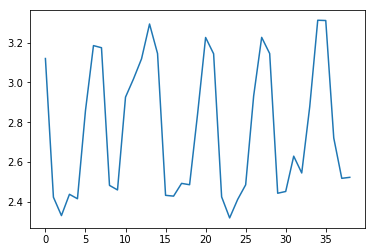

In [31]:
plt.plot(testpreds[129])

In [32]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [33]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              1.839132   
air_0164b9927d20bcc3_2017-04-23              1.333509   
air_0241aa3964b7f861_2017-04-23              2.392286   
air_0328696196e46f18_2017-04-23              2.136304   
air_034a3d5b40d5b1b1_2017-04-23              3.515188   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   5.291073  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   2.794334  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23   9.938474  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   7.468085  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  32.622257

In [34]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [35]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [36]:
submission.to_csv("../submission/l5_3006_xgb_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')